In [2]:
import sys
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
sys.path.insert(0, '..')  # Add the parent dir to the system path
%reload_ext autoreload
%autoreload 2
%aimport helper

helper.info()

torch version: 2.3.0
device: cpu


TRAIN dataset size: 800
TEST  dataset size: 200


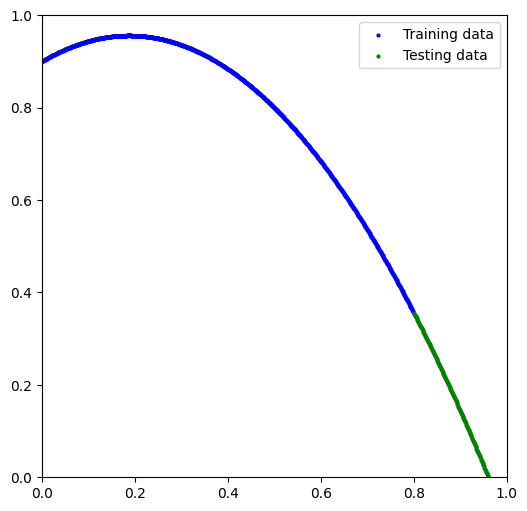

In [4]:
X = torch.arange(0, 1, 0.001)
y = -1.6 * X * X + 0.6 * X + 0.9
# y = 0.5 * X + 0.2

# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

helper.plot_predictions(X_train, y_train, X_test, y_test, None)

train_ds = TensorDataset(X_train, y_train)
print(f'TRAIN dataset size: {len(train_ds)}')

test_ds = TensorDataset(X_test, y_test)
print(f'TEST  dataset size: {len(test_ds)}')

In [5]:
class PolynomialModel(nn.Module):
    def __init__(self):
        super().__init__() 
        # self.w3 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.w2 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.w1 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.w0 = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.w2 * x * x + self.w1 * x + self.w0
    
torch.manual_seed(2)
model_0 = PolynomialModel()
model_0.state_dict()

OrderedDict([('w2', tensor([0.3923])),
             ('w1', tensor([-0.2236])),
             ('w0', tensor([-0.3195]))])

Epoch:  100 | MAE Train Loss: 0.00315 | MAE Test Loss: 0.05725 
Epoch:  200 | MAE Train Loss: 0.00228 | MAE Test Loss: 0.03600 
Epoch:  300 | MAE Train Loss: 0.00165 | MAE Test Loss: 0.02315 
Epoch:  400 | MAE Train Loss: 0.00092 | MAE Test Loss: 0.01546 
Epoch:  500 | MAE Train Loss: 0.00046 | MAE Test Loss: 0.00997 
Epoch:  600 | MAE Train Loss: 0.00041 | MAE Test Loss: 0.00631 
Epoch:  700 | MAE Train Loss: 0.00026 | MAE Test Loss: 0.00410 
Epoch:  800 | MAE Train Loss: 0.00014 | MAE Test Loss: 0.00268 
Epoch:  900 | MAE Train Loss: 0.00009 | MAE Test Loss: 0.00178 
Epoch: 1000 | MAE Train Loss: 0.00007 | MAE Test Loss: 0.00111 
Epoch: 1100 | MAE Train Loss: 0.00003 | MAE Test Loss: 0.00073 
Epoch: 1200 | MAE Train Loss: 0.00003 | MAE Test Loss: 0.00046 
Epoch: 1300 | MAE Train Loss: 0.00002 | MAE Test Loss: 0.00031 
Epoch: 1400 | MAE Train Loss: 0.00001 | MAE Test Loss: 0.00019 
Epoch: 1500 | MAE Train Loss: 0.00001 | MAE Test Loss: 0.00012 
Epoch: 1600 | MAE Train Loss: 0.00000 | 

OrderedDict([('w2', tensor([-1.5810])),
             ('w1', tensor([0.5844])),
             ('w0', tensor([0.9022]))])

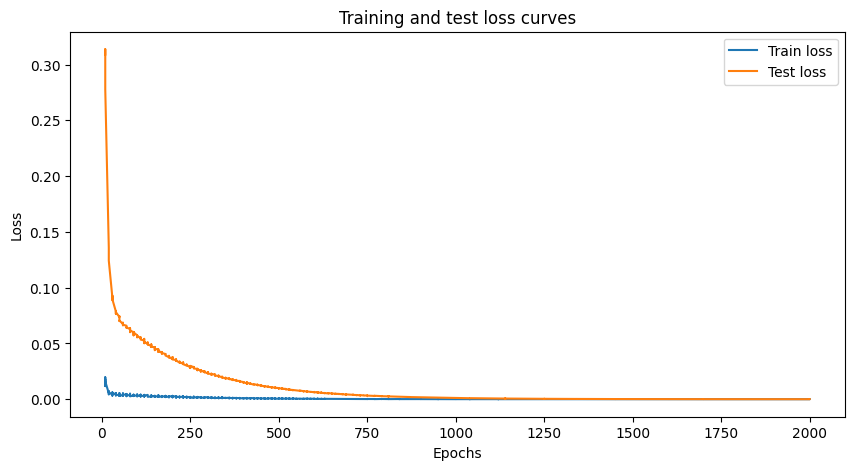

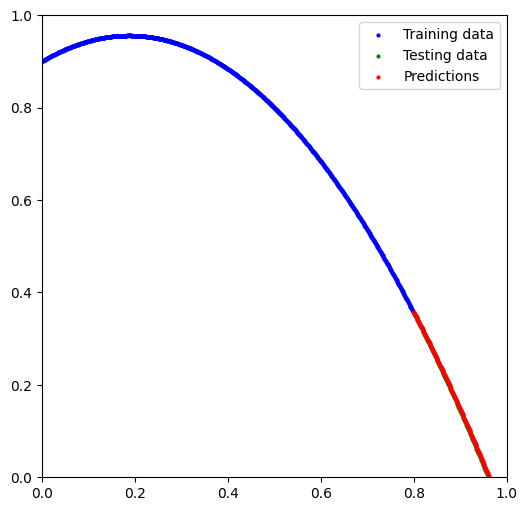

In [6]:
torch.manual_seed(2)

train_dl = DataLoader(train_ds, batch_size=50, shuffle=True)

model_0 = PolynomialModel()
# loss_fn = nn.L1Loss() # MAE
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.05)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 2000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(1, epochs+1):
    for i, (inputs, targets) in enumerate(train_dl):
        ### Training
        #
        # Forward pass
        outputs = model_0(inputs)
        loss = loss_fn(outputs, targets)
        #
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # gradient descent (update the parameters)

        ### Testing
        # Print out what's happening
        if epoch % 10 == 0:
            model_0.eval()
            with torch.inference_mode():
                test_pred = model_0(X_test) # forward pass
                test_loss = loss_fn(test_pred, y_test.type(torch.float))
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            if i == 0 and epoch % 100 == 0:
                print(f"Epoch: {epoch:4d} | MAE Train Loss: {loss:.5f} | MAE Test Loss: {test_loss:.5f} ")

display(model_0.state_dict())

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

with torch.inference_mode(): 
    y_preds = model_0(X_test)

helper.plot_predictions(X_train, y_train, X_test, y_test, y_preds)